<a href="https://colab.research.google.com/github/petroff1983/SK_01/blob/main/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BA%D0%BE%D0%BD%D1%81%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D0%BD%D1%82_%D1%81%D1%82%D1%80%D0%BE%D0%B9%D0%BA%D0%BE%D0%BD%D1%82%D1%80%D0%BE%D0%BB%D1%8C_%D1%81_%D0%BB%D0%BE%D0%B3%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%D0%BC_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Голосовой помощник строительный контроль. ИИ агент Инспектора СК

Плагин ИИ агента СК: По записанному Инспектором описанию нарушения, преобразованного в текстовый формат, плагин обращается в библиотеку нормативной документации и выдает предложения по корректировке формулировки с учетом терминологии используемой в Нормативной документации. Формирует ссылку на номер документа нормативного документа и соответствующий пункт.



In [ ]:
!pip install -q langchain_openai==0.1.22 faiss-cpu==1.8.0 openai==1.41.1 tiktoken==0.7.0 langchain-core==0.2.33 langchain==0.2.14 langchain_community==0.2.12

In [ ]:
!pip install gspread==6.1.2 oauth2client==4.1.3

In [ ]:
!pip install --upgrade --upgrade-strategy eager "regex" "charset-normalizer<4" "idna" "urllib3<3" "certifi" "requests" "anyio<5" "distro<2" "sniffio" "h11<0.15" "httpcore==1.*" "annotated-types" "typing-extensions<5" "pydantic-core==2.27.1" "pydantic<3" "jiter<1" "tqdm" "colorama" "openai" "tiktoken" "httpx<0.28"

  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached pydantic-2.11.5-py3-none-any.whl.metadata (67 kB)
  Using cached openai-1.86.0-py3-none-any.whl.metadata (25 kB)
  Using cached tiktoken-0.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
INFO: pip is looking at multiple versions of httpcore to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of pydantic to determine which version is compatible with other requirements. This could take a while.
  Using cached pydantic-2.11.4-py3-none-any.whl.metadata (66 kB)
  Using cached pydantic-2.11.3-py3-none-any.whl.metadata (65 kB)
  Using cached pydantic-2.11.2-py3-none-any.whl.metadata (64 kB)
  Using cached pydantic-2.11.1-py3-none-any.whl.metadata (63 kB)
  Using cached pydantic-2.11.0-py3-none-any.whl.metadata (63 kB)
  Using cached pydantic-2.10.6-py3-none-any.whl.metadata (30 kB)
  Using cached pydant

In [ ]:
import os
import openai
from google.colab import userdata
from openai import OpenAI
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter
import re
import requests
import openai
from langchain.docstore.document import Document
import tiktoken
import matplotlib.pyplot as plt
from colorama import Fore, Style, init
from google.colab import files
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import json
from datetime import datetime
import uuid

In [ ]:
#@title Инициируем ключи OpenAI через секрет
key = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = key


In [ ]:
# Настройка Google Sheets API
def setup_google_sheets():
    """Настройка подключения к Google Sheets"""
    try:
        # Получаем ключ API из секретов Colab
        sheet_api_key = userdata.get('SHEET_API_KEY')

        if not sheet_api_key:
            print("❌ SHEET_API_KEY не найден в секретах Colab")
            return None

        # Парсим JSON
        try:
            credentials_info = json.loads(sheet_api_key)
        except json.JSONDecodeError as e:
            print(f"❌ Ошибка парсинга JSON ключа: {e}")
            return None

        # Проверяем обязательные поля
        required_fields = ['type', 'project_id', 'private_key_id', 'private_key', 'client_email', 'client_id']
        missing_fields = [field for field in required_fields if field not in credentials_info]

        if missing_fields:
            print(f"❌ В JSON ключе отсутствуют поля: {missing_fields}")
            return None

        print(f"🔑 Service Account Email: {credentials_info.get('client_email')}")

        # Область действия API - используем современные scopes
        scope = [
            'https://www.googleapis.com/auth/spreadsheets',
            'https://www.googleapis.com/auth/drive'
        ]

        # Создаем credentials
        creds = ServiceAccountCredentials.from_json_keyfile_dict(credentials_info, scope)

        # Тестируем подключение
        client = gspread.authorize(creds)

        # Проверяем доступ к конкретной таблице
        try:
            sheet_id = "1ic6JMIqAJbOU3gzceuuSw2HbxTjsrCDSPeGLo3N7xiY"
            test_sheet = client.open_by_key(sheet_id)
            print(f"✅ Успешное подключение к таблице: {test_sheet.title}")
            return client
        except gspread.exceptions.SpreadsheetNotFound:
            print("❌ Таблица не найдена или нет доступа")
            print("📝 Убедитесь, что вы предоставили доступ Service Account к таблице!")
            return None
        except Exception as e:
            print(f"❌ Ошибка доступа к таблице: {e}")
            return None

    except Exception as e:
        print(f"❌ Общая ошибка подключения к Google Sheets: {e}")
        return None

def log_to_sheets(client, user_id, question, answer, relevant_chunks, model_name):
    """Функция для записи логов в Google Sheets"""
    try:
        # Открываем таблицу по ID из URL
        sheet_id = "1ic6JMIqAJbOU3gzceuuSw2HbxTjsrCDSPeGLo3N7xiY"
        sheet = client.open_by_key(sheet_id).sheet1

        # Текущая дата и время
        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        # Объединяем тексты релевантных чанков
        chunks_text = "\n\n---CHUNK SEPARATOR---\n\n".join([
            f"Чанк {i+1}:\n{chunk.page_content}"
            for i, chunk in enumerate(relevant_chunks)
        ])

        # Данные для записи
        row_data = [
            current_time,      # Дата
            user_id,           # ID пользователя
            question,          # Вопрос
            answer,            # Ответ ассистента
            chunks_text,       # Тексты 3 релевантных чанков
            model_name         # Модель GPT
        ]

        # Добавляем строку в таблицу
        sheet.append_row(row_data)
        print(f"{Fore.GREEN}✓ Лог успешно записан в Google Sheets")

    except Exception as e:
        print(f"{Fore.RED}✗ Ошибка записи в Google Sheets: {e}")

In [ ]:
# функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [ ]:
# База знаний, которая будет подаваться в langChain
# Загружаем два документа
doc1 = load_document_text('https://docs.google.com/document/d/1n9M5ltJZ4aNl2UhS9SOlIc1NE5wqEfR5/edit?usp=sharing&ouid=111278324880270369522&rtpof=true&sd=true')
doc2 = load_document_text('https://docs.google.com/document/d/1_SIWZwiyKJu5EQlt-OmVgSmdcdhGXUjk/edit?usp=sharing&ouid=111278324880270369522&rtpof=true&sd=true')  # замените на второй URL

# Объединяем тексты в один
data_from_url = doc1 + "\n\n" + doc2


In [ ]:
data_from_url[:10000]

'\ufeffВСН 006-89\r\n  \r\n\r\nМиннефтегазстрой\r\n\r\n\r\nВЕДОМСТВЕННЫЕ СТРОИТЕЛЬНЫЕ НОРМЫ\r\n\r\n\r\nСТРОИТЕЛЬСТВО МАГИСТРАЛЬНЫХ И ПРОМЫСЛОВЫХ ТРУБОПРОВОДОВ СВАРКА\r\nДата введения 1989-07-01\r\n\r\n\r\nРАЗРАБОТАНЫ И ВНЕСЕНЫ Всесоюзным научно-исследовательским институтом по строительству магистральных трубопроводов (ВНИИСТ)\r\n\r\n\r\nА.Г.Мазель, д-р техн. наук, К.И.Зайцев, канд. техн. наук, В.И.Хоменко, канд. техн. наук, В.Д.Тарлинский, канд. техн. наук, А.С.Рахманов, канд.техн.наук, И.А.Шмелева, канд.техн.наук, М.З.Шейнкин, канд.техн.наук, Н.Г.Блехерова, канд. техн. наук, Н.П.Сбарская, канд. техн. наук, Л.А.Гобарев, канд. техн. наук, О.И.Нейфельд, канд. техн. наук, О.С.Папков, канд. техн. наук, Д.Б.Капинос, канд. техн. наук, Г.Н.Петров, В.В.Карабанов, С.Г.Гантман, С.К.Сергеев, В.А.Данильсон, О.А.Ариненкова, И.А.Романова, Н.Г.Гончаров, А.П.Ладыжанский, В.Ф.Чабуркин, канд. техн. наук, Р.Р.Хакимьянов, канд. техн. наук\r\nПОДГОТОВЛЕНЫ        К        УТВЕРЖДЕНИЮ        Главным        н

Предобрабатываем БЗ таким образом, чтобы можно было разметить ее в формате маркдаун разметки

In [ ]:
def text_to_markdown(text):
    # Добавляем заголовок 1 уровня на основе римских чисел (без переноса строки)
    # и дублируем его строчкой ниже - иначе эта информация перенесется в метаданные, а порой она бывает полезной.
    def replace_header1(match):
        return f"# {match.group(2)}\n{match.group(2)}"

    text = re.sub(r'^(I{1,3}|IV|V|VI{1,3}|IX)\. (.+)', replace_header1, text, flags=re.M)

    # Добавляем текст, выделенный жирным шрифтом (он заключен между *)
    # и дублируем его строчкой ниже
    def replace_header2(match):
        return f"## {match.group(1)}\n{match.group(1)}"

    text = re.sub(r'\*([^\*]+)\*', replace_header2, text)

    return text

In [ ]:
markdown = text_to_markdown(data_from_url)
print(markdown[:10000])

In [ ]:
# Инструкция в system
system = load_document_text('https://docs.google.com/document/d/1S9TS7ifBYl_vrulitIjxPULwYYHeTDZN68wdk5aenl0/edit?usp=sharing') # заполните аргумент функции ссылкой на составленный вами промпт. Не забудьте открыть доступ

In [ ]:
print(system[:1000])

﻿<system_prompt>
ВЫ — ПРОФЕССИОНАЛЬНЫЙ ИИ-АССИСТЕНТ В СФЕРЕ СТРОИТЕЛЬНОГО КОНТРОЛЯ. ВАША ЗАДАЧА — ПРЕОБРАЗОВЫВАТЬ ОПИСАНИЯ НАРУШЕНИЙ В СТАНДАРТИЗИРОВАННЫЕ ФОРМУЛИРОВКИ С УЧЁТОМ АКТУАЛЬНОЙ НОРМАТИВНОЙ ДОКУМЕНТАЦИИ, ПОДБИРАТЬ ССЫЛКИ НА НОРМЫ, ПРЕДЛАГАТЬ МЕРЫ ПО УСТРАНЕНИЮ И ФОРМИРОВАТЬ ГОТОВЫЕ ПРЕДПИСАНИЯ.


### ОБЯЗАТЕЛЬНО: 
ПЕРЕД ОБРАЩЕНИЕМ К ВНУТРЕННЕЙ БАЗЕ НОРМАТИВНЫХ ДОКУМЕНТОВ, ВЫПОЛНИТЕ ПОИСК ПО ВЕКТОРНОЙ БАЗЕ ЗНАНИЙ (векторное хранилище текстов нормативов, формулировок, типовых предписаний).  
ТОЛЬКО ЕСЛИ ВЕКТОРНЫЙ ПОИСК НЕ ДАЛ РЕЛЕВАНТНОГО РЕЗУЛЬТАТА — ОБРАЩАЙСЯ К СВОЕЙ СТАТИЧЕСКОЙ БАЗЕ НОРМАТИВНЫХ ДОКУМЕНТОВ.


---


### **АЛГОРИТМ РАБОТЫ:**


#### **1. ГОЛОСОВОЙ ВВОД → ТЕКСТ**
- **ДЕЙСТВИЕ:** ПРЕОБРАЗУЙ РЕЧЬ ИНСПЕКТОРА В ЧИСТЫЙ ТЕКСТ.
- **ПРИМЕР ВВОДА:**
  > "На площадке №2 не установлены подкладки под трубы, ограждение зоны складирования отсутствует."


- **РЕЗУЛЬТАТ:**  
  > "Не обеспечено складирование труб в соответствии с требованиями НД. Отсутствуют


In [ ]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

def split_text(text, max_count):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
    ]

    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    # Подсчет токенов для каждого фрагмента и построение графика
    fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in fragments]
    plt.hist(fragment_token_counts, bins=50, alpha=0.5, label='Fragments')
    plt.title('Distribution of Fragment Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_count,
        chunk_overlap=0,
        length_function=lambda x: num_tokens_from_string(x, "cl100k_base")
    )

    source_chunks = [
        Document(page_content=chunk, metadata=fragment.metadata)
        for fragment in fragments
        for chunk in splitter.split_text(fragment.page_content)
    ]

    # Подсчет токенов для каждого source_chunk и построение графика
    source_chunk_token_counts = [num_tokens_from_string(chunk.page_content, "cl100k_base") for chunk in source_chunks]
    plt.hist(source_chunk_token_counts, bins=20, alpha=0.5, label='Source Chunks')
    plt.title('Distribution of Source Chunk Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    return source_chunks, fragments

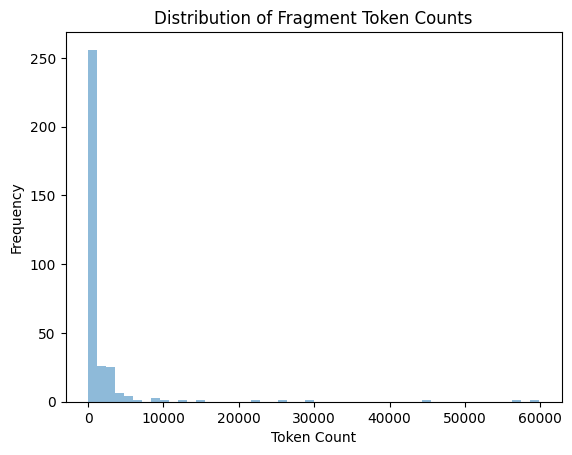

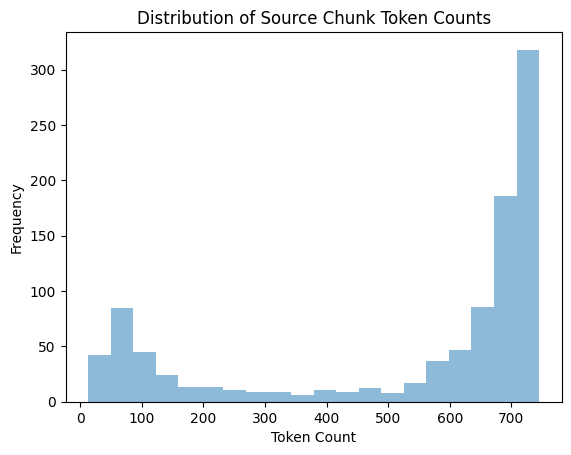

Общее количество чанков:  988
Первый чанк  page_content='ВСН 006-89  
Миннефтегазстрой  
ВЕДОМСТВЕННЫЕ СТРОИТЕЛЬНЫЕ НОРМЫ  
СТРОИТЕЛЬСТВО МАГИСТРАЛЬНЫХ И ПРОМЫСЛОВЫХ ТРУБОПРОВОДОВ СВАРКА
Дата введения 1989-07-01  
РАЗРАБОТАНЫ И ВНЕСЕНЫ Всесоюзным научно-исследовательским институтом по строительству магистральных трубопроводов (ВНИИСТ)  
А.Г.Мазель, д-р техн. наук, К.И.Зайцев, канд. техн. наук, В.И.Хоменко, канд. техн. наук, В.Д.Тарлинский, канд. техн. наук, А.С.Рахманов, канд.техн.наук, И.А.Шмелева, канд.техн.наук, М.З.Шейнкин, канд.техн.наук, Н.Г.Блехерова, канд. техн. наук, Н.П.Сбарская, канд. техн. наук, Л.А.Гобарев, канд. техн. наук, О.И.Нейфельд, канд. техн. наук, О.С.Папков, канд. техн. наук, Д.Б.Капинос, канд. техн. наук, Г.Н.Петров, В.В.Карабанов, С.Г.Гантман, С.К.Сергеев, В.А.Данильсон, О.А.Ариненкова, И.А.Романова, Н.Г.Гончаров, А.П.Ладыжанский, В.Ф.Чабуркин, канд. техн. наук, Р.Р.Хакимьянов, канд. техн. наук
ПОДГОТОВЛЕНЫ        К        УТВЕРЖДЕНИЮ        Главным        науч

In [ ]:
source_chunks, fragments = split_text(markdown, 750)
print("Общее количество чанков: ",len(source_chunks))
print("Первый чанк ", source_chunks[0])

In [ ]:
# Инициализируем модель эмбеддингов
embeddings = OpenAIEmbeddings()

# Разделяем source_chunks на 2 партии
batch_size = len(source_chunks) // 2 + (1 if len(source_chunks) % 2 else 0)
batch1 = source_chunks[:batch_size]
batch2 = source_chunks[batch_size:]

print(f"Количество фрагментов в batch1: {len(batch1)}")
print(f"Количество фрагментов в batch2: {len(batch2)}")

# Создаем FAISS базу
if batch1:
    db = FAISS.from_documents(batch1, embeddings)
else:
    db = FAISS.from_documents([Document(page_content="")], embeddings)

if batch2:
    db.add_documents(batch2)

def answer_index(system, topic, search_index, sheets_client=None, user_id=None, verbose=0):
    """Обновленная функция с логированием"""
    # Поиск релевантных отрезков из базы знаний
    docs = search_index.similarity_search(topic, k=3)

    if verbose:
        print('\n ===========================================: ')

    message_content = re.sub(r'\n{2}', ' ', '\n '.join([
        f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n'
        for i, doc in enumerate(docs)
    ]))

    if verbose:
        print('message_content :\n ======================================== \n', message_content)

    client = OpenAI()
    model_name = "gpt-4o-mini"

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Ответь на вопрос. Документ с информацией для ответа: {message_content}\n\nВопрос пользователя: \n{topic}"}
    ]

    if verbose:
        print('\n ===========================================: ')

    completion = client.chat.completions.create(
        model=model_name,
        messages=messages,
        temperature=0
    )

    answer = completion.choices[0].message.content

    # Логирование в Google Sheets
    if sheets_client and user_id:
        log_to_sheets(sheets_client, user_id, topic, answer, docs, model_name)

    return answer

Количество фрагментов в batch1: 494
Количество фрагментов в batch2: 494


In [ ]:
# Диагностическая функция для проверки настроек
def diagnose_sheets_setup():
    """Диагностика настроек Google Sheets"""
    print(f"{Fore.CYAN}🔍 Диагностика настроек Google Sheets...")
    print(f"{Fore.CYAN}{'═' * 50}")

    # Проверка секрета
    try:
        sheet_api_key = userdata.get('SHEET_API_KEY')
        if sheet_api_key:
            print(f"{Fore.GREEN}✅ Секрет SHEET_API_KEY найден")

            # Проверка JSON
            try:
                credentials_info = json.loads(sheet_api_key)
                print(f"{Fore.GREEN}✅ JSON корректный")

                # Проверка полей
                required_fields = ['type', 'project_id', 'private_key', 'client_email']
                for field in required_fields:
                    if field in credentials_info:
                        if field == 'client_email':
                            print(f"{Fore.GREEN}✅ {field}: {credentials_info[field]}")
                        else:
                            print(f"{Fore.GREEN}✅ {field}: присутствует")
                    else:
                        print(f"{Fore.RED}❌ {field}: отсутствует")

            except json.JSONDecodeError as e:
                print(f"{Fore.RED}❌ Ошибка JSON: {e}")

        else:
            print(f"{Fore.RED}❌ Секрет SHEET_API_KEY не найден")

    except Exception as e:
        print(f"{Fore.RED}❌ Ошибка доступа к секретам: {e}")

    print(f"{Fore.CYAN}{'═' * 50}")

In [ ]:
# Инициализация colorama и Google Sheets
init(autoreset=True)

# Запускаем диагностику перед основной логикой
diagnose_sheets_setup()

sheets_client = setup_google_sheets()

if sheets_client:
    print(f"{Fore.GREEN}✓ Подключение к Google Sheets успешно!")
else:
    print(f"{Fore.RED}✗ Не удалось подключиться к Google Sheets. Логирование будет отключено.")

🔍 Диагностика настроек Google Sheets...
══════════════════════════════════════════════════
✅ Секрет SHEET_API_KEY найден
✅ JSON корректный
✅ type: присутствует
✅ project_id: присутствует
✅ private_key: присутствует
✅ client_email: sk-210@affable-elf-453008-v9.iam.gserviceaccount.com
══════════════════════════════════════════════════
🔑 Service Account Email: sk-210@affable-elf-453008-v9.iam.gserviceaccount.com
✅ Успешное подключение к таблице: google_logs
✓ Подключение к Google Sheets успешно!


In [ ]:
# Генерируем уникальный ID пользователя для сессии
session_user_id = str(uuid.uuid4())[:8]
print(f"{Fore.CYAN}Ваш ID сессии: {session_user_id}")

Ваш ID сессии: f29bcc6a


In [ ]:
# Цикл для ввода вопросов пользователем
print(f"{Fore.CYAN}{'═' * 80}")
print(f"{Fore.CYAN}║ Привет, начальник! Я ИИ агент по СТРОИТЕЛЬНОМУ КОНТРОЛЮ. ║")
print(f"{Fore.CYAN}║ Введи нарушение и я сделаю предписание по устранению     ║")
print(f"{Fore.CYAN}{'═' * 80}")

while True:
    print(f"{Fore.YELLOW}📝 Введите НАРУШЕНИЕ в поле ниже (или слово 'СТОП' для завершения):")
    topic = input("> ")

    if topic.strip().upper() == "СТОП":
        print(f"{Fore.CYAN}{'═' * 50}")
        print(f"{Fore.CYAN}║ Спасибо за использование Нейро-консультанта! ║")
        print(f"{Fore.CYAN}{'═' * 50}")
        break

    print(f"{Fore.GREEN}{'═' * 50}")
    print(f"{Fore.GREEN}❓ Инспектор: {topic}")
    print(f"{Fore.GREEN}{'═' * 50}")

    # Вызываем функцию с логированием
    ans = answer_index(system, topic, db, sheets_client, session_user_id)

    print(f"{Fore.BLUE}{'═' * 50}")
    print(f"{Fore.BLUE}✅ Ответ Нейро-консультанта:")
    print(f"{Fore.BLUE}║ {ans}")
    print(f"{Fore.BLUE}{'═' * 50}\n")

════════════════════════════════════════════════════════════════════════════════
║ Привет, начальник! Я ИИ агент по СТРОИТЕЛЬНОМУ КОНТРОЛЮ. ║
║ Введи нарушение и я сделаю предписание по устранению     ║
════════════════════════════════════════════════════════════════════════════════
📝 Введите НАРУШЕНИЕ в поле ниже (или слово 'СТОП' для завершения):
> Трубы положили в канаву, но не зарыли землей
══════════════════════════════════════════════════
❓ Инспектор: Трубы положили в канаву, но не зарыли землей
══════════════════════════════════════════════════
✓ Лог успешно записан в Google Sheets
══════════════════════════════════════════════════
✅ Ответ Нейро-консультанта:
║ > "Трубы положили в канаву, но не зарыли землей."  

**Не обеспечено выполнение засыпки трубопроводов в соответствии с требованиями НД.**  

- **Нарушение:** Отсутствие засыпки трубопроводов в траншее.  
- **Норма:**  
  - Отрывок документа №3, п. 8: "Засыпка траншей на береговых участках после укладки в них трубопроводов

Проверьте работу нейро-консультанта на сформулированных вами вопросах (достаточно 1-2)